In [1]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import json
import os
import shutil
import sys
sys.path.append("..")

from PJT_Frustration_Induced_Crystallize.main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
# cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"

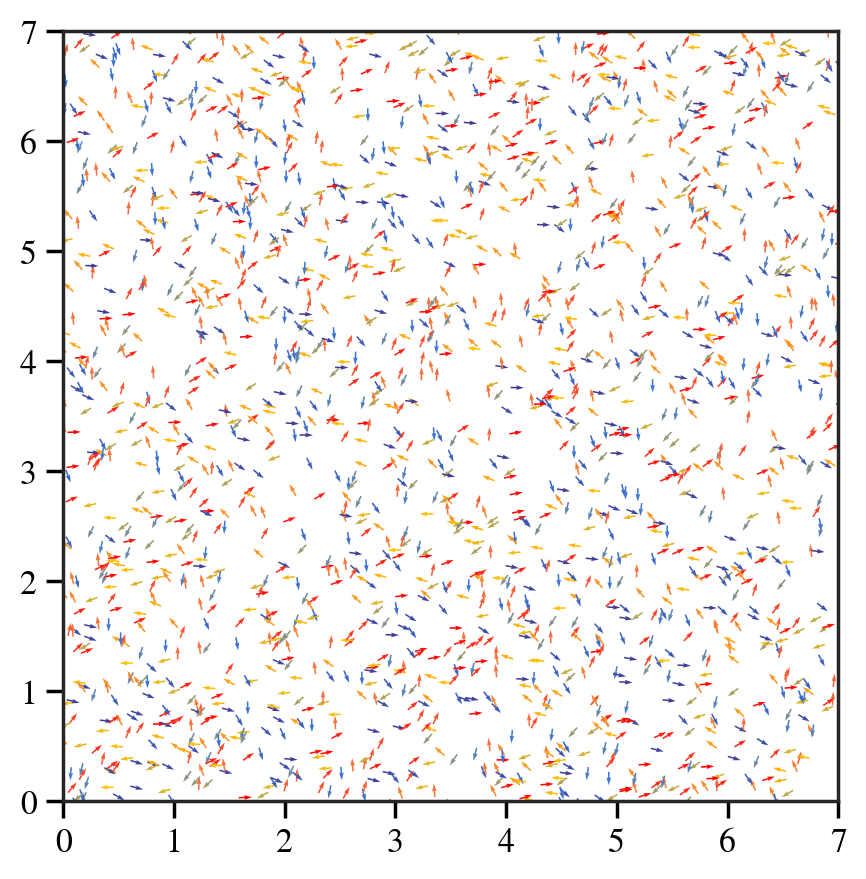

In [7]:
model = PhaseLagPatternFormation05pi(
    strengthK=20, distanceD0=1.55,
    agentsNum=2000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
    randomSeed=10, overWrite=False
)
model.plot()

In [8]:
model.run(40000)

F:\MS_ExperimentData\general/PhaseLagPatternFormation05pi(strengthK=20.000,distanceD0=1.550,phaseLagA0=1.571,boundaryLength=7.0,speedV=3.0,freqDist=uniform,omegaMin=0.000,deltaOmega=0.000,agentsNum=2000,dt=0.005,shotsnaps=10,randomSeed=10).h5 already exists, but has only 2001 snapshots, will continue to run until 4002 snapshots.


  0%|          | 0/20009 [00:00<?, ?it/s]

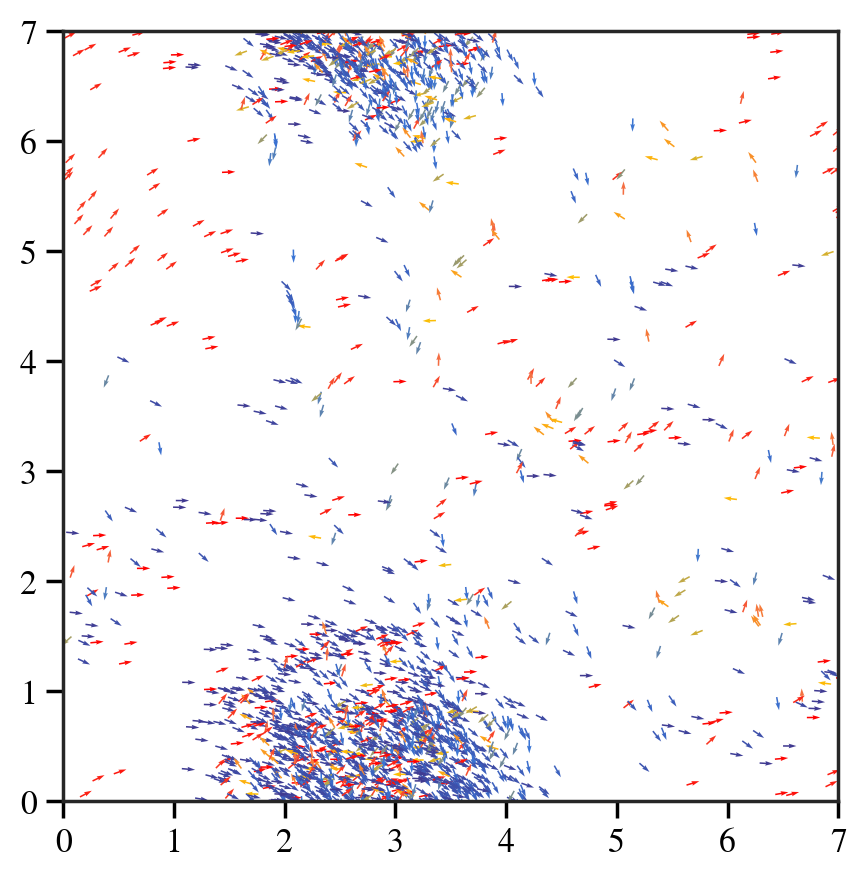

In [9]:
model.plot()

40001

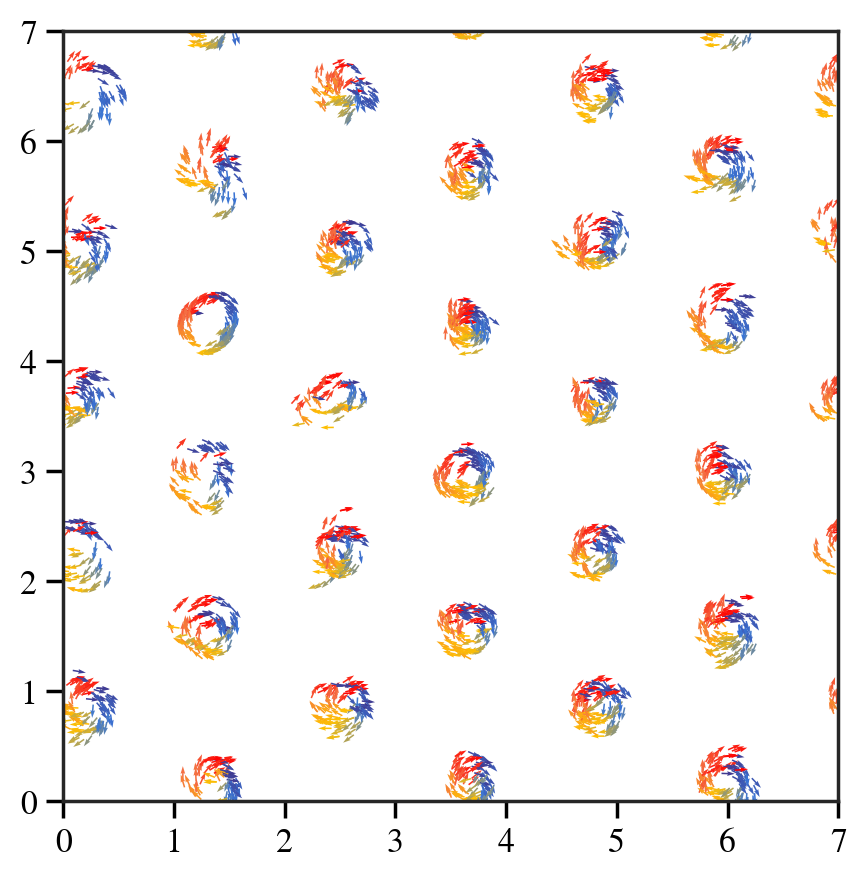

In [3]:
sa = StateAnalysis(model)
sa.plot_spatial(colorsBy="phase")
sa.TNum

In [4]:
shift = np.array([0., 0.])
analysisRadius = model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))

classes, centers = sa.calc_classes_and_centers(classDistance=analysisRadius, lookIdx=-1)
if len(classes) > model.agentsNum * 0.2:
    raise ValueError(f"Too many classes: {len(classes)} > {model.agentsNum * 0.2}, skipping.")
numInClasses = np.array([len(c) for c in classes])
# zScoreNum = stats.zscore(numInClasses)
# classes = [classes[c] for c in range(len(classes)) 
#            if (zScoreNum[c] > -0.4) and (numInClasses[c] > 10)]
numThres = np.median(numInClasses[numInClasses > 10]) * 0.
classes = [classes[c] for c in range(len(classes))
            if (numInClasses[c] > max(numThres, 10))]
centers = np.mod(centers + shift, model.boundaryLength)
if len(classes) <= 1:
    raise ValueError("Not enough classes, skipping.")

classCenters: List[np.ndarray] = []
for c in classes:
    singleClassCenters = centers[c]

    maxDeltaX = np.abs(singleClassCenters[:, 0] - singleClassCenters[:, 0, np.newaxis]).max()
    subXShift = model.halfBoundaryLength if maxDeltaX > model.halfBoundaryLength else 0
    maxDeltaY = np.abs(singleClassCenters[:, 1] - singleClassCenters[:, 1, np.newaxis]).max()
    subYShift = model.halfBoundaryLength if maxDeltaY > model.halfBoundaryLength else 0

    singleClassCenters = np.mod(singleClassCenters - np.array([subXShift, subYShift]), model.boundaryLength)
    classCenter = np.mod(singleClassCenters.mean(axis=0) + np.array([subXShift, subYShift]), model.boundaryLength)
    classCenters.append(classCenter)
classCenters: np.ndarray = np.array(classCenters)

edges, ajdClassCenters = sa.calc_nearby_edges(
    classCenters=classCenters, 
    stdMulti=0.3,
    relativeDistance=False
)

classAnalRadius = list()

for _, oscIdx in enumerate(classes):
    freqOmega: np.ndarray = sa.model.freqOmega[oscIdx]
    meanFreq = freqOmega.mean()
    analRadius = model.speedV / np.abs(meanFreq - model.strengthK * np.sin(model.phaseLagA0))
    
    classAnalRadius.append(analRadius)

classAnalRadius = np.array(classAnalRadius)
edgeDistances = np.array([
    sa.calc_replative_distance(ajdClassCenters[edge[0]], ajdClassCenters[edge[1]]) 
    for edge in edges
])

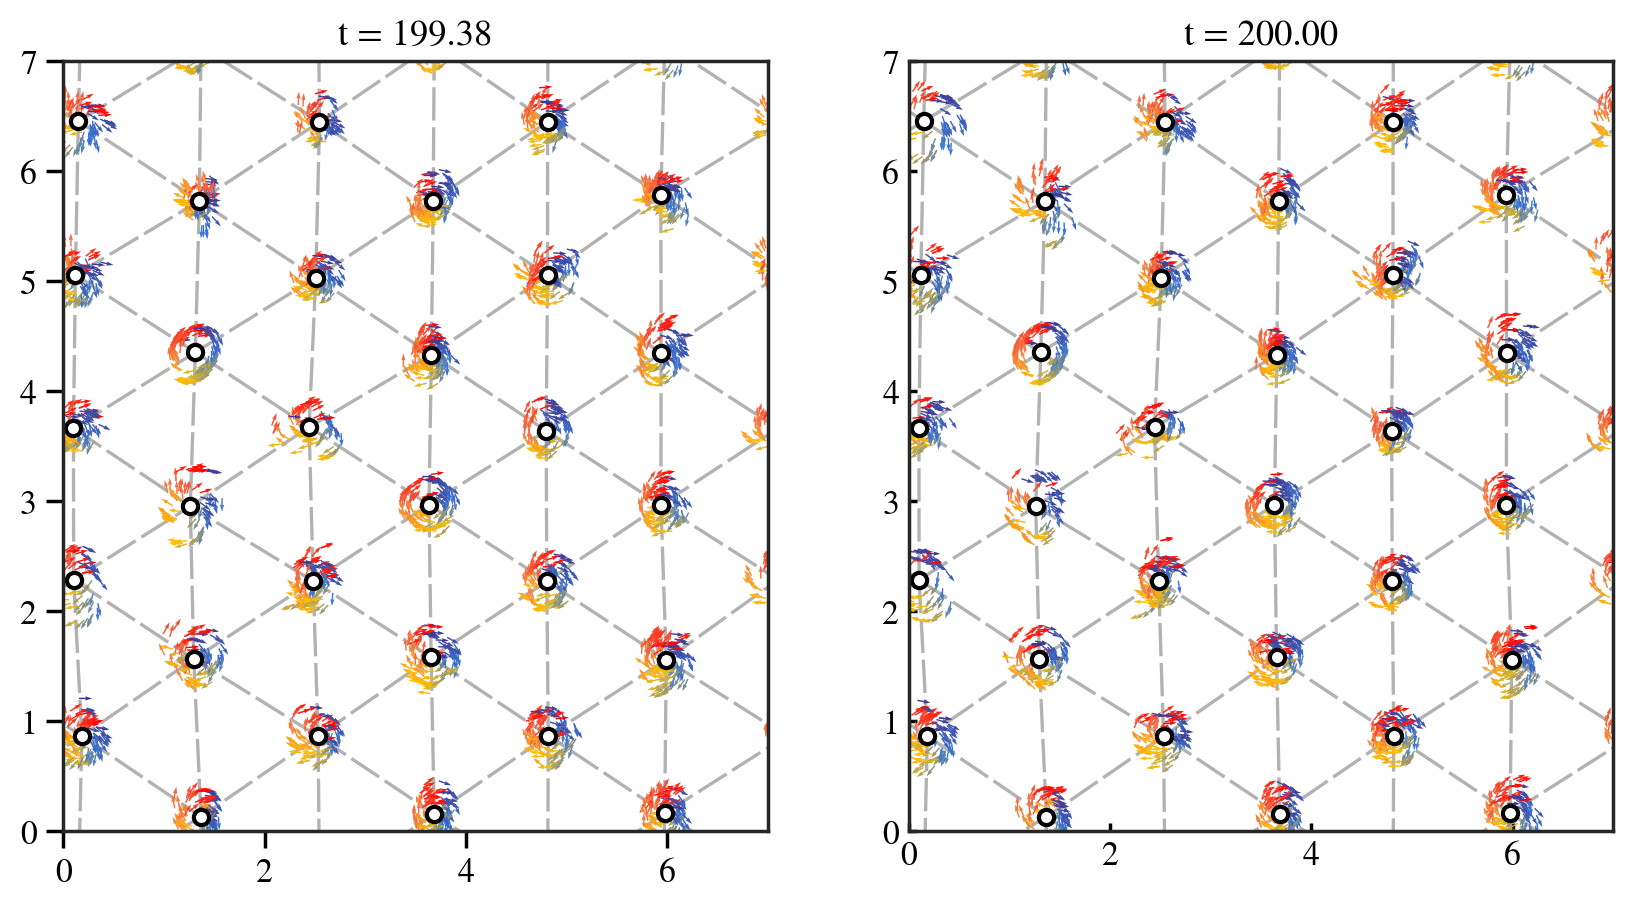

In [23]:
# fig, ax = plt.subplots(figsize=(5, 5))
indexs = [-125, -1]
colNum = len(indexs)
fig, axs = plt.subplots(1, colNum, figsize=(colNum * 5, 5))

for i in range(len(indexs)):
    ax = axs[i]
    sa.plot_spatial(ax=ax, colorsBy="phase", index=indexs[i], shift=shift)
    ax.scatter(
        classCenters[:, 0], classCenters[:, 1],
        facecolor="white", s=30, edgecolor="black", lw=1.5
    )
    for edge in edges:
        ax.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1],
                color="black", lw=1.2, alpha=0.3, linestyle=(0, (10, 2)), zorder=0)
    ax.set_title(f"t = {(sa.TNum + indexs[i]) * model.dt:.2f}") 

plt.tick_params(length=3, direction="in")

([], [])

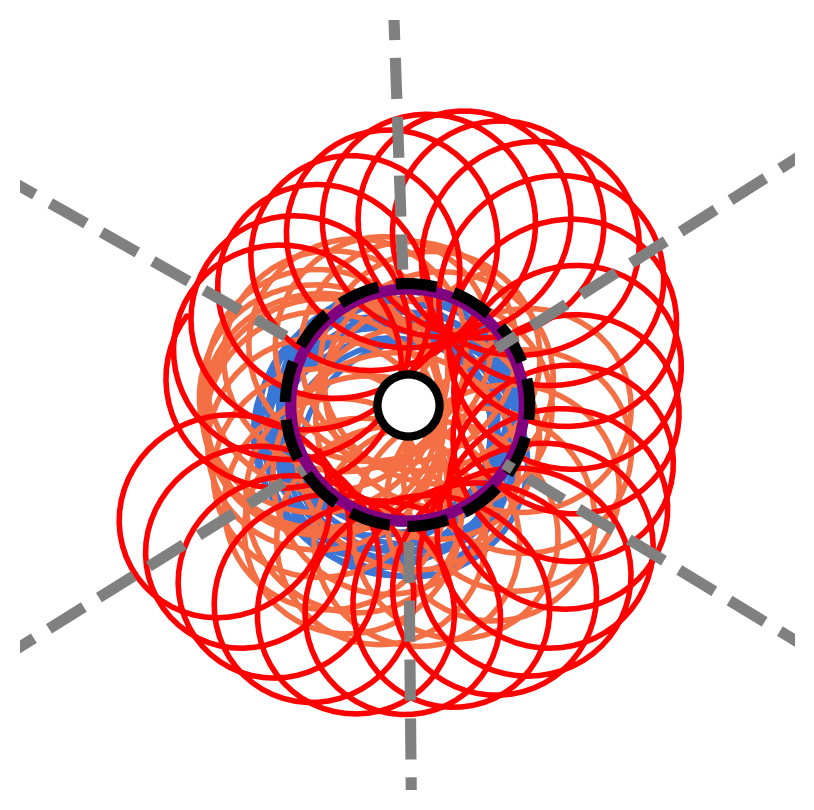

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(
    classCenters[:, 0], classCenters[:, 1],
    facecolor="white", s=500, edgecolor="black", lw=3, zorder=1000
)

for edge in edges[:]:
    # plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1],
    #          color="black", lw=1.2, alpha=0.3, linestyle=(0, (10, 2)), zorder=0)
    edgeCenter = (ajdClassCenters[edge[0]] + ajdClassCenters[edge[1]]) / 2
    edgeNodesDelta = ajdClassCenters[edge[0]] - ajdClassCenters[edge[1]]
    edgeAngle = np.arctan2(edgeNodesDelta[1], edgeNodesDelta[0])
    edgeShift = np.array([np.cos(edgeAngle), np.sin(edgeAngle)]) * 0.53 * model.distanceD0

    plt.plot([edgeCenter[0] - edgeShift[0], edgeCenter[0] + edgeShift[0]], 
             [edgeCenter[1] - edgeShift[1], edgeCenter[1] + edgeShift[1]],
             lw=4, alpha=1, color="gray", ls="--", zorder=1000)

for analRadius, classCenter in zip(
    classAnalRadius, classCenters
):
    circle = plt.Circle(
        classCenter, analRadius * 1, color="black", fill=False, lw=4, alpha=1, ls="--"
    )
    ax.add_artist(circle)

# sa.plot_spatial(ax=ax, colorsBy="phase", index=-1, shift=shift)

focusClassIdx = 4

focusParticleIdx = classes[focusClassIdx]
positionX = sa.totalPositionX[-1][focusParticleIdx] + shift
phaseTheta = sa.totalPhaseTheta[-1][focusParticleIdx]
colors = [cmap(i) for i in
    np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)
]
# ax.quiver(
#     positionX[:, 0], positionX[:, 1],
#     np.cos(phaseTheta), np.sin(phaseTheta), 
#     # scale_units='inches', scale=15.0, width=0.002,
#     color=colors
# )
timeCounts = [1000, 1600, 1500]
trajectoryColors = ["#3A76D6", "#F46F43", "#FF0000", "#403990", "#FFC001"]
for i, singleSelectIdx in enumerate([7, 3, 1]):
    ax.plot(
        sa.totalPositionX[-timeCounts[i]:, focusParticleIdx[singleSelectIdx], 0],
        sa.totalPositionX[-timeCounts[i]:, focusParticleIdx[singleSelectIdx], 1],
        color=trajectoryColors[i], alpha=1, lw=2, zorder=0
    )


focusCenter = classCenters[focusClassIdx]
halfWidth = 0.5

plt.xlim(focusCenter[0] - halfWidth, focusCenter[0] + halfWidth)
plt.ylim(focusCenter[1] - halfWidth, focusCenter[1] + halfWidth)

plt.tick_params(length=3, direction="in")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.xticks([])
plt.yticks([])

In [8]:
focusClassIdx = 4
focusParticleIdx = classes[focusClassIdx]
singleSelectIdx = 1

tailTimes = 2000
trajectory = sa.totalPositionX[-tailTimes:, focusParticleIdx[singleSelectIdx]]
phaseTheta = sa.totalPhaseTheta[-tailTimes:, focusParticleIdx[singleSelectIdx]]
tailRotationCenters = [
    sa.calc_rotation_center(lookIdx=-i)
    for i in tqdm(np.arange(tailTimes, 1, -5))
]
tailRotationCenters = np.array(tailRotationCenters)

  0%|          | 0/400 [00:00<?, ?it/s]

(0.3621557981855811, 1.3621557981855812)

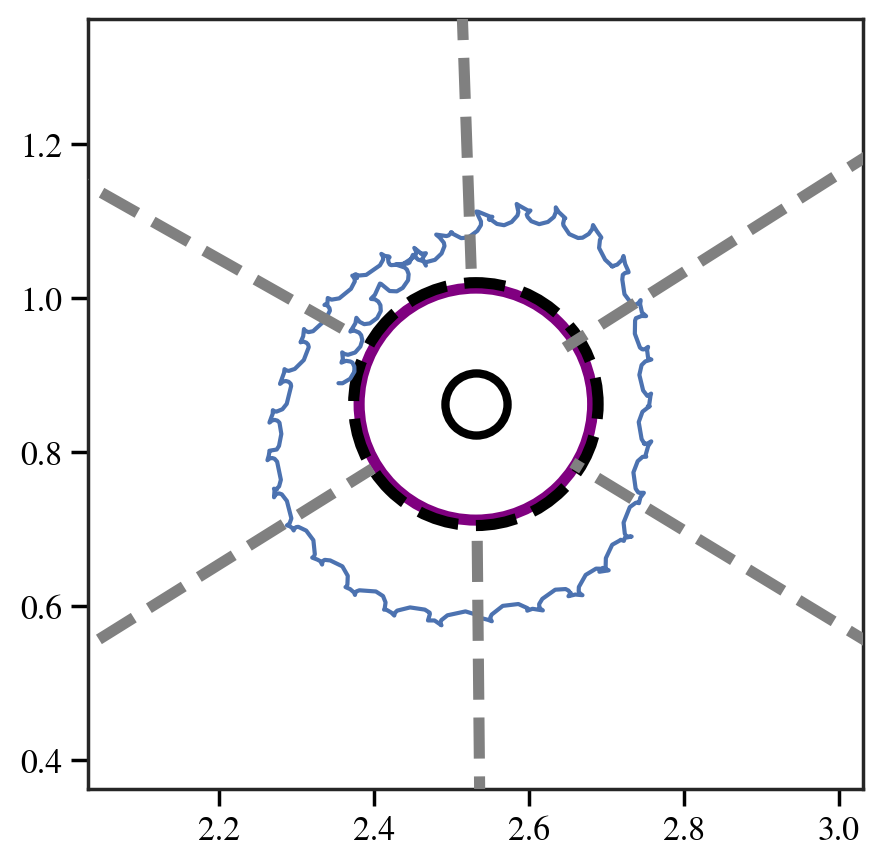

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(
    classCenters[:, 0], classCenters[:, 1],
    facecolor="white", s=500, edgecolor="black", lw=3, zorder=1000
)

for edge in edges[:]:
    # plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1],
    #          color="black", lw=1.2, alpha=0.3, linestyle=(0, (10, 2)), zorder=0)
    edgeCenter = (ajdClassCenters[edge[0]] + ajdClassCenters[edge[1]]) / 2
    edgeNodesDelta = ajdClassCenters[edge[0]] - ajdClassCenters[edge[1]]
    edgeAngle = np.arctan2(edgeNodesDelta[1], edgeNodesDelta[0])
    edgeShift = np.array([np.cos(edgeAngle), np.sin(edgeAngle)]) * 0.53 * model.distanceD0

    plt.plot([edgeCenter[0] - edgeShift[0], edgeCenter[0] + edgeShift[0]], 
             [edgeCenter[1] - edgeShift[1], edgeCenter[1] + edgeShift[1]],
             lw=4, alpha=1, color="gray", ls="--", zorder=1000)

for analRadius, effRadius, classCenter in zip(
    classAnalRadius, classEffRadius, classCenters
):
    circle = plt.Circle(
        classCenter, effRadius * 1, 
        color="purple", fill=False, lw=4, alpha=1
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        classCenter, analRadius * 1, color="black", fill=False, lw=4, alpha=1, ls="--"
    )
    ax.add_artist(circle)

focusClassIdx = 4
focusParticleIdxs = classes[focusClassIdx]
singleSelectIdx = 1
focusParticleIdx = focusParticleIdxs[singleSelectIdx]

focusParRotCenters = tailRotationCenters[:, focusParticleIdx]
plt.plot(focusParRotCenters[:, 0], focusParRotCenters[:, 1])
# plt.scatter(
#     focusParRotCenters[:, 0], focusParRotCenters[:, 1],
#     facecolor="white", s=30, edgecolor="black", lw=1.5, zorder=1000
# )

halfWidth = 0.5

plt.xlim(focusCenter[0] - halfWidth, focusCenter[0] + halfWidth)
plt.ylim(focusCenter[1] - halfWidth, focusCenter[1] + halfWidth)

(-3.0, 3.0)

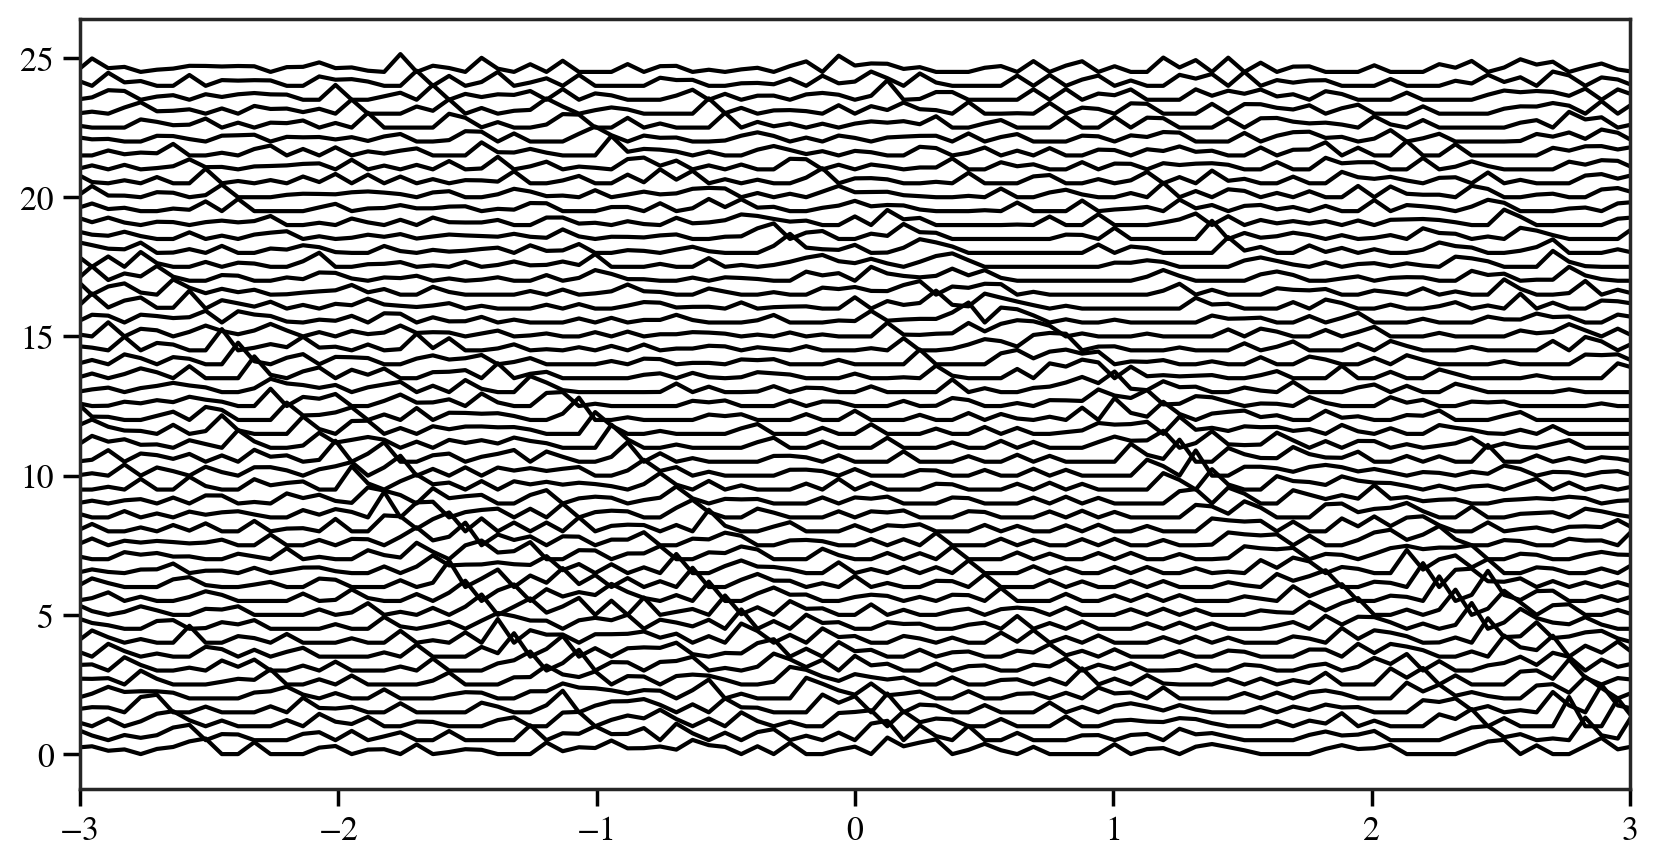

In [ ]:
focusClassIdx = 4
focusParticleIdxs = classes[focusClassIdx]
singleSelectIdx = 1
focusParticleIdx = focusParticleIdxs[singleSelectIdx]

tailCounts = 50
trajectory = sa.totalPositionX[-tailCounts:, focusParticleIdxs]
phaseTheta = sa.totalPhaseTheta[-tailCounts:, focusParticleIdxs]
focusCenter = classCenters[focusClassIdx]
deltaX = trajectory - focusCenter
radius = np.linalg.norm(deltaX, axis=-1)
angle = np.arctan2(deltaX[:, :, 1], deltaX[:, :, 0])

fig, ax = plt.subplots(figsize=(10, 5))

for t in range(radius.shape[0]):
    subRadius = radius[t, :]
    subAngle = angle[t, :]
    argsortedIdxs = np.argsort(subAngle, axis=0)
    sortedRadius = subRadius[argsortedIdxs]
    sortedAngle = subAngle[argsortedIdxs]
    # plt.plot(sortedAngle, 
    #         #  sortedRadius + t * 0.1,
    #          pd.Series(sortedRadius).rolling(2, center=True, min_periods=1).mean() + t * 0.08,
    #          lw=1.5, alpha=1, color="black")
    hist, bins = np.histogram(sortedAngle, bins=50, range=(-np.pi, np.pi), weights=sortedRadius)
    plt.plot(bins[:-1], hist + t * 0.5, lw=1.5, alpha=1, color="black")

plt.xlim(-3, 3)

In [ ]:
model = PhaseLagPatternFormation1D(strengthK=20, distanceD0=1, phaseLagA0=0.6*np.pi, 
                                  dt=0.001,
                                  tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
                                  randomSeed=9, overWrite=True)
model.run(80000)

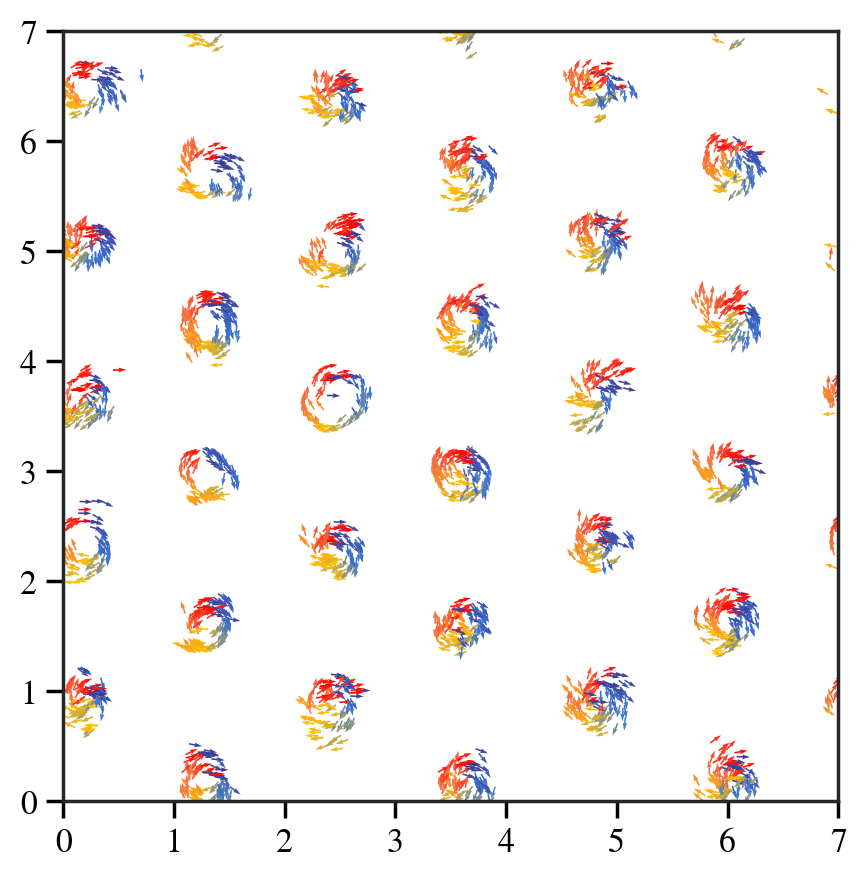

In [3]:
model = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    agentsNum=3000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=1, 
    randomSeed=10, overWrite=False
)
sa = StateAnalysis(model)
sa.plot_spatial(colorsBy="phase")

classes, centers = sa.calc_classes_and_centers(classDistance=0.5, lookIdx=-1)
tailDotPhaseThetas = np.array([sa.calc_dot_theta(lookIdx=i) for i in np.arange(-1000, 0, 10)])
effectiveFreqs = tailDotPhaseThetas.mean(axis=0)

classCenters = np.array([centers[c].mean(axis=0) for c in classes])
periodicEdges, adjClassCenters = sa.calc_nearby_edges(classCenters=classCenters)

classPosPerent = list()
classNegPerent = list()
classMeanPosFreq = list()
classMeanNegFreq = list()
classMeanFreq = list()
classMeanEffFreq = list()
classMaxRadius = list()

for classIdx, oscIdx in enumerate(classes):
    freqOmega: np.ndarray = sa.model.freqOmega[oscIdx]

    posPerent = (freqOmega >= 0).mean()
    negPerent = (freqOmega < 0).mean()
    
    meanPosFreq = freqOmega[freqOmega >= 0].mean() if np.any(freqOmega >= 0) else 0
    meanNegFreq = freqOmega[freqOmega < 0].mean() if np.any(freqOmega < 0) else 0

    meanFreq = freqOmega.mean()
    meanEffFreq = effectiveFreqs[oscIdx].mean()

    maxRadius = sa.calc_replative_distance(sa.totalPositionX[-1000:, oscIdx], 
                                           classCenters[classIdx]).max()
    
    classPosPerent.append(posPerent)
    classNegPerent.append(negPerent)
    classMeanPosFreq.append(meanPosFreq)
    classMeanNegFreq.append(meanNegFreq)
    classMeanFreq.append(meanFreq)
    classMeanEffFreq.append(meanEffFreq)
    classMaxRadius.append(maxRadius)

classPosPerent = np.array(classPosPerent)
classNegPerent = np.array(classNegPerent)
classMeanPosFreq = np.array(classMeanPosFreq)
classMeanNegFreq = np.array(classMeanNegFreq)

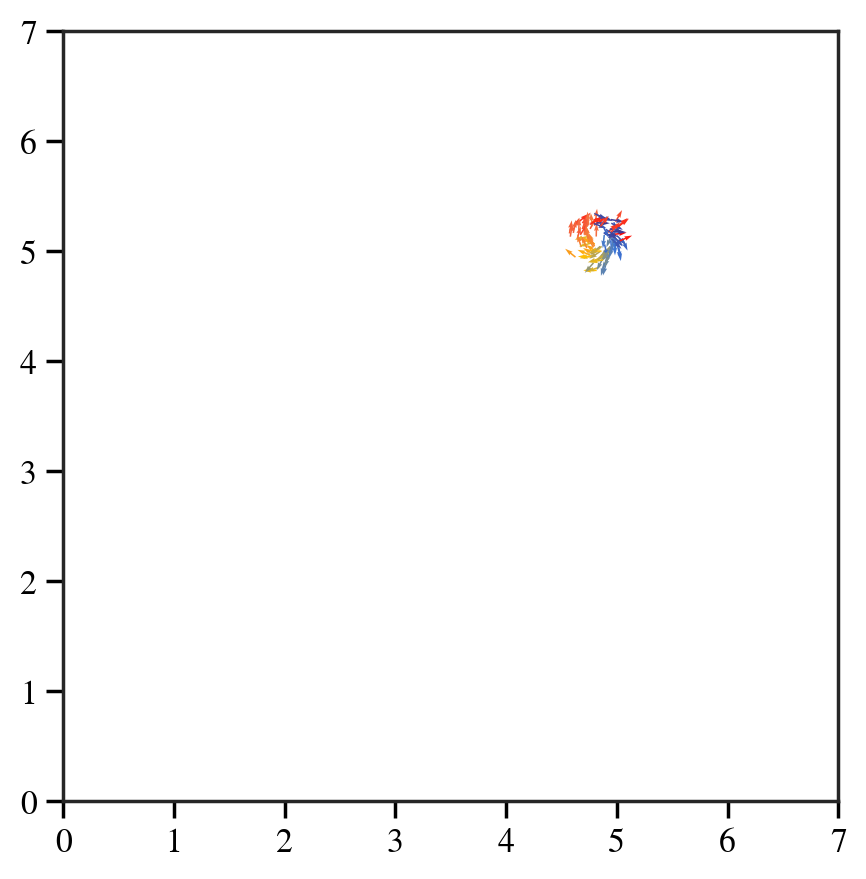

In [4]:
reduceModel = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    agentsNum=len(classes[0]), dt=0.001,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=1, 
    randomSeed=9, overWrite=True
)

subIndexs = classes[1]

reduceModel.positionX = sa.totalPositionX[-1][subIndexs].copy()
reduceModel.phaseTheta = sa.totalPhaseTheta[-1][subIndexs].copy()
reduceModel.freqOmega = sa.model.freqOmega[subIndexs].copy()
reduceModel.agentsNum = len(subIndexs)
reduceModel.plot(colorsBy="phase")

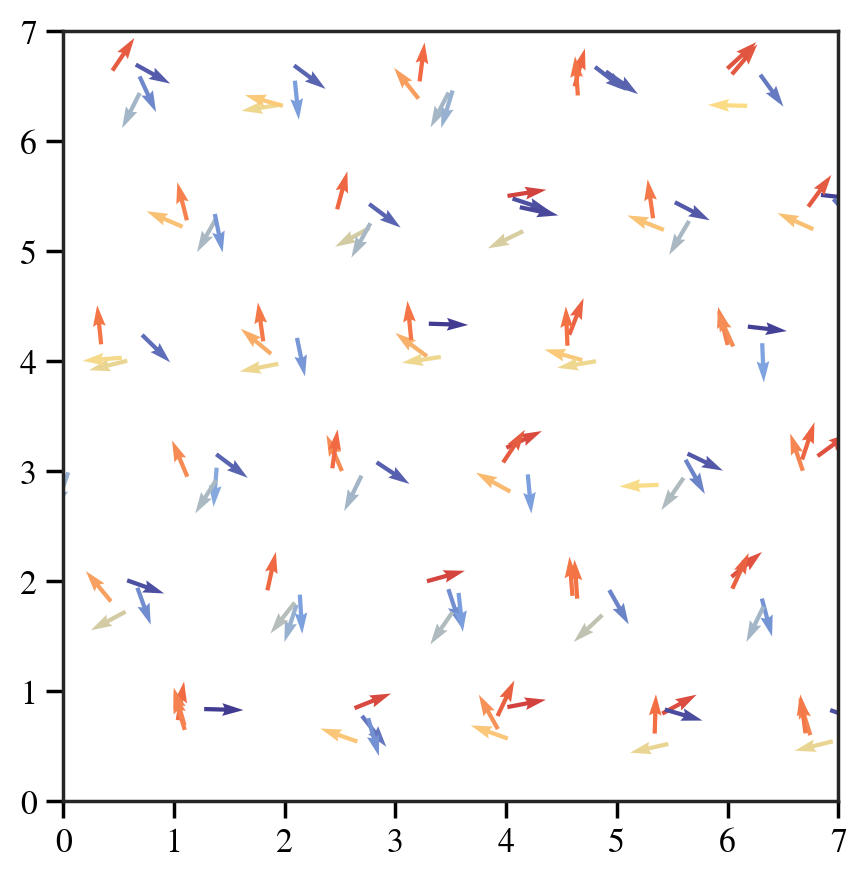

In [25]:
frontCounts = 4

reduceModel = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    agentsNum=len(classes) * frontCounts, dt=0.001,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
    randomSeed=9, overWrite=True
)

subIndexs = np.concatenate([c[:frontCounts] for c in classes])

reduceModel.positionX = sa.totalPositionX[-1][subIndexs].copy()
reduceModel.phaseTheta = sa.totalPhaseTheta[-1][subIndexs].copy()
reduceModel.freqOmega = sa.model.freqOmega[subIndexs].copy()
reduceModel.plot(colorsBy="phase")

In [5]:
reduceModel.run(10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

(4.0, 6.0)

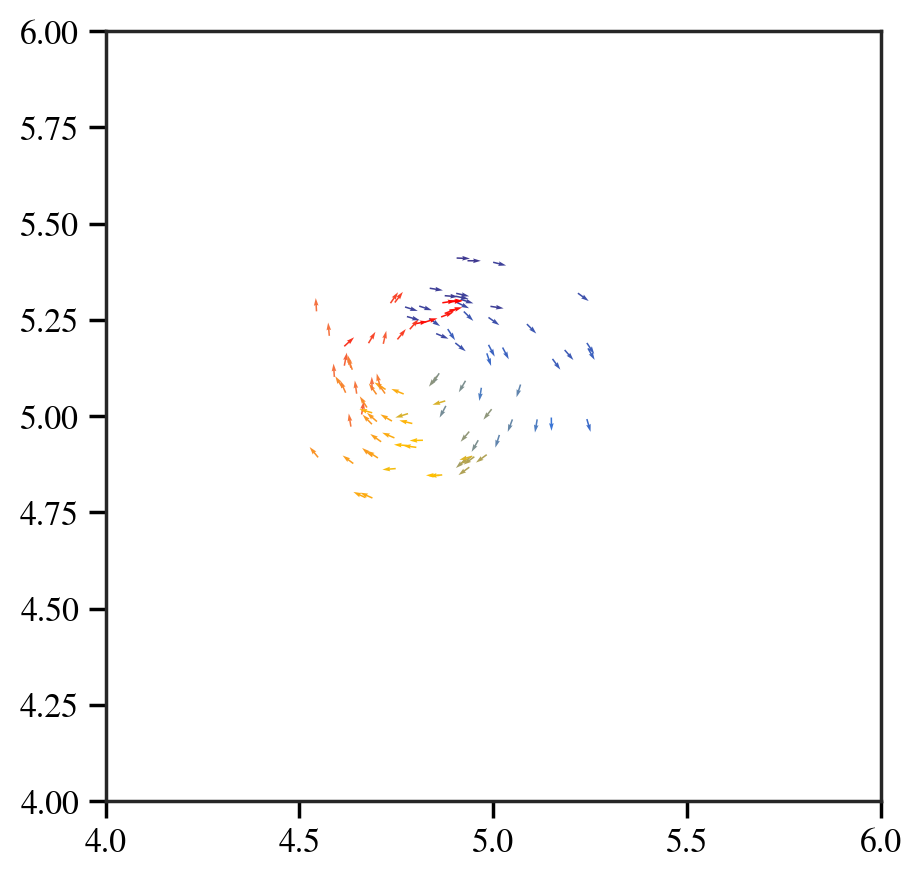

In [8]:
reduceModel.plot(colorsBy="phase")
plt.xlim(4, 6)
plt.ylim(4, 6)